# NBA MVP Prediction

## Appending the csv files to create the Dataset 

In [1]:
import pandas as pd
import pathlib
import random as rd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.neighbors import BallTree
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn import tree

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
nba_dataset = pd.DataFrame()

for season in np.arange(1981,2021,1):
    df = pd.read_csv(f'./data/{season}_std.csv', low_memory=False)    
    nba_dataset = nba_dataset.append(df)

display(nba_dataset)
display(nba_dataset.info())

,Player,Pos,Age,G,MP,FG,FGA,FG%,3P,3PA,...,WS,WS/48,OBPM,DBPM,BPM,VORP,First,Share,Status,Season
0,Kareem Abdul-Jabbar,C,33,80,2976,836,1457,0.574,0,1,...,14.3,0.230,4.7,1.4,6.1,6.1,8,0.414,Candidate,1981
1,Tom Abernethy,SF,26,39,298,25,59,0.424,0,1,...,0.4,0.062,-2.2,-0.4,-2.6,0.0,0,0.000,OOR,1981
2,Alvan Adams,C,26,75,2054,458,870,0.526,0,0,...,7.7,0.180,2.5,2.6,5.1,3.7,0,0.000,OOR,1981
3,Darrell Allums,PF,22,22,276,23,67,0.343,0,1,...,-0.3,-0.054,-5.5,-0.1,-5.6,-0.3,0,0.000,OOR,1981
4,Tiny Archibald,PG,32,80,2820,382,766,0.499,0,9,...,6.9,0.118,0.9,-1.0,-0.1,1.4,0,0.046,Candidate,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
524,Trae Young,PG,21,60,2120,546,1249,0.437,205,568,...,5.9,0.133,6.2,-2.3,3.9,3.1,0,0.000,OOR,2020
525,Cody Zeller,C,27,58,1341,251,479,0.524,18,75,...,3.6,0.129,0.2,-0.8,-0.6,0.5,0,0.000,OOR,2020
526,Tyler Zeller,C,30,2,4,1,4,0.250,0,0,...,0.0,-0.075,-0.3,-22.1,-22.4,0.0,0,0.000,OOR,2020
527,Ante Žižić,C,23,22,221,41,72,0.569,0,0,...,0.5,0.106,-1.7,-1.5,-3.2,-0.1,0,0.000,OOR,2020


<class 'pandas.core.frame.DataFrame'>
Int64Index: 16852 entries, 0 to 528
Data columns (total 51 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  16852 non-null  object 
 1   Pos     16852 non-null  object 
 2   Age     16852 non-null  int64  
 3   G       16852 non-null  int64  
 4   MP      16852 non-null  int64  
 5   FG      16852 non-null  int64  
 6   FGA     16852 non-null  int64  
 7   FG%     16852 non-null  float64
 8   3P      16852 non-null  int64  
 9   3PA     16852 non-null  int64  
 10  3P%     16852 non-null  float64
 11  2P      16852 non-null  int64  
 12  2PA     16852 non-null  int64  
 13  2P%     16852 non-null  float64
 14  eFG%    16852 non-null  float64
 15  FT      16852 non-null  int64  
 16  FTA     16852 non-null  int64  
 17  FT%     16852 non-null  float64
 18  ORB     16852 non-null  int64  
 19  DRB     16852 non-null  int64  
 20  TRB     16852 non-null  int64  
 21  AST     16852 non-null  int64  
 22  

None

Way too many features, we need to remove some of them.

## Feature Removing

In [3]:
cols = ['G','MP','FG','FG%','3P','2P','FT','TRB','DRB%','ORB%','OWS','DWS','WS/48','OBPM','DBPM','First']
print(f"Removing {len(cols)} features.")
nba_dataset = nba_dataset.drop(columns=cols)

Removing 16 features.


## Feature Analysis

<AxesSubplot:>

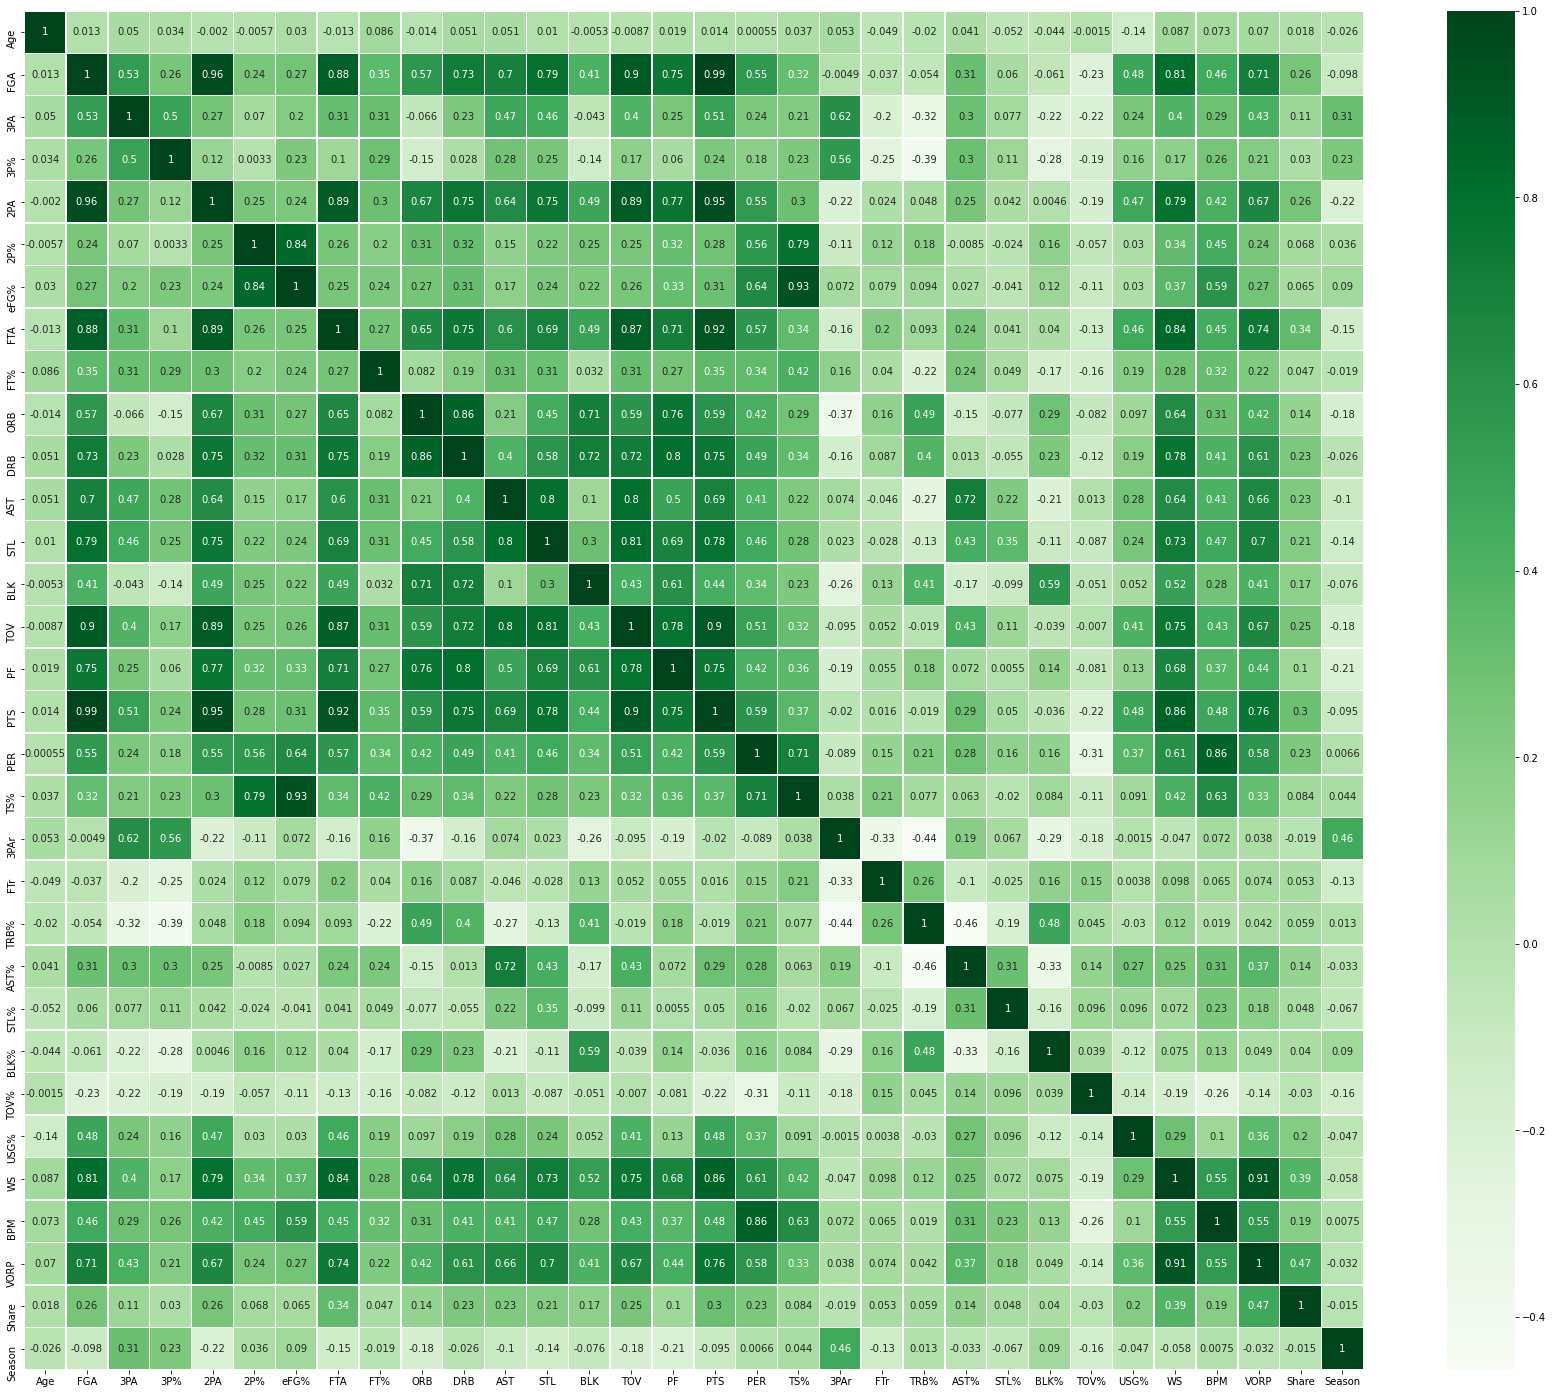

In [4]:
plt.figure(figsize=(30, 25))
sns.heatmap(nba_dataset.corr(), annot=True, cmap='Greens', linewidths=0.5)

I'm gonna keep some features just for further analysis. Once they are not usefull anymore I'll take them out.

## Outlier Analysis

### Functions Definition

In [5]:
def limit_calc(column):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

In [6]:
def boxplot(column):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=column, ax=ax1)
    ax2.set_xlim(limit_calc(column))
    sns.boxplot(x=column, ax=ax2)
    
def histogram(column,color=None):
    plt.figure(figsize=(15, 5))
    sns.histplot(column,color=color)

def bar_chart(column):  
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=column.value_counts().index, y=column.value_counts())
    ax.set_xlim(limit_calc(column))

### 3-Point Field Goal Percentage

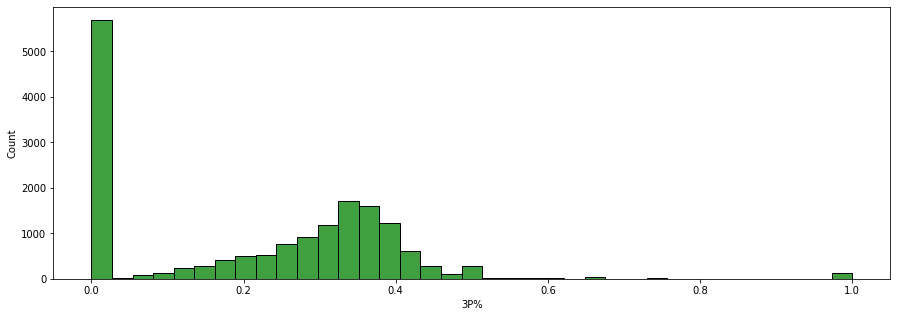

In [7]:
histogram(nba_dataset['3P%'],"Green")

Probably a fews guys had 1 3-pt attempt and managed to score. Those sharpshooters with 100% accuracy gonna be taken out.

Besides that, I gave 3 conditions to keep a player in the Dataset.
<ol>
    <li>Players within the margin: 0% ~ 60% </li>
    <li>Players with more than 60% accuracy can be counted if they tried at least 50 shoots in the season</li>
    <li>Kept the MVP and Candidates regardless their accuracy  </li>  
</ol>

In [8]:
min_val = 0.0
max_val = 0.6

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['3P%'] >= min_val) & (nba_dataset['3P%'] <= max_val)) 
                              | (nba_dataset['3P%'] > max_val) & (nba_dataset['3PA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

193 rows removed


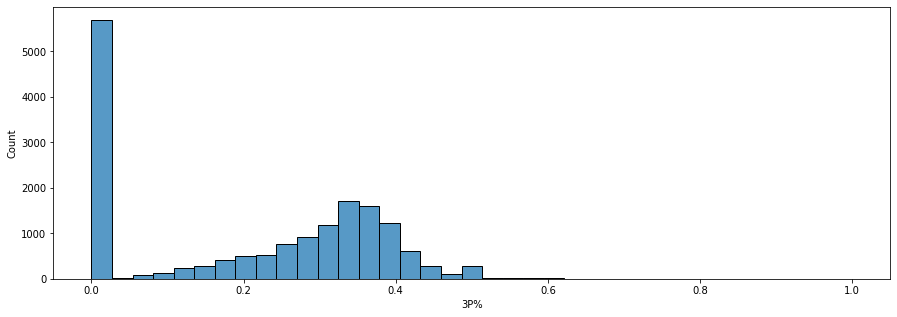

In [9]:
histogram(nba_dataset['3P%'])

### 2-Point Field Goal Percentage

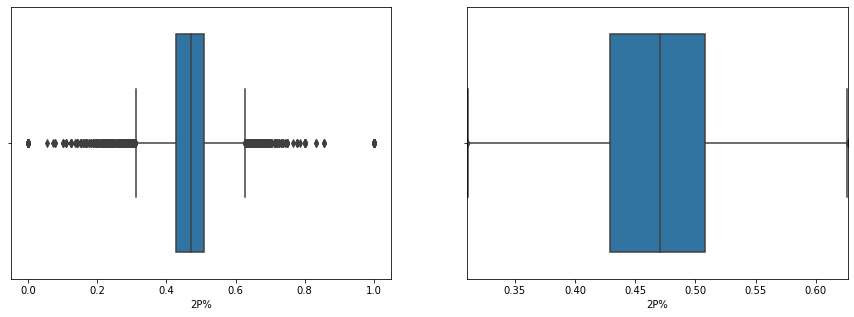

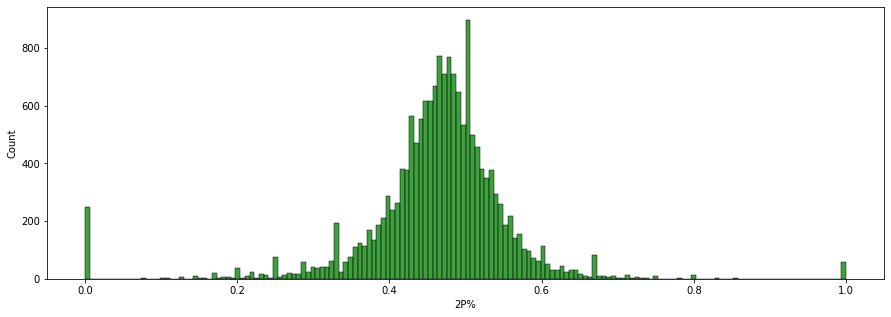

In [10]:
boxplot(nba_dataset['2P%'])
histogram(nba_dataset['2P%'],"Green")

Here again, some bench warmers are generating a few outliers.

The same 3 conditions will be repeated.<br> 
Here we gonna use a quantile (25% - 75%) calculation for the margins and we will consider 250 attempts to validate a outlier accuracy.

In [11]:
min_val, max_val = limit_calc(nba_dataset['2P%'])

df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[((nba_dataset['2P%'] >= min_val) & (nba_dataset['2P%'] <= max_val)) 
                              | (nba_dataset['2P%'] > max_val) & (nba_dataset['2PA'] >= 250)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

1039 rows removed


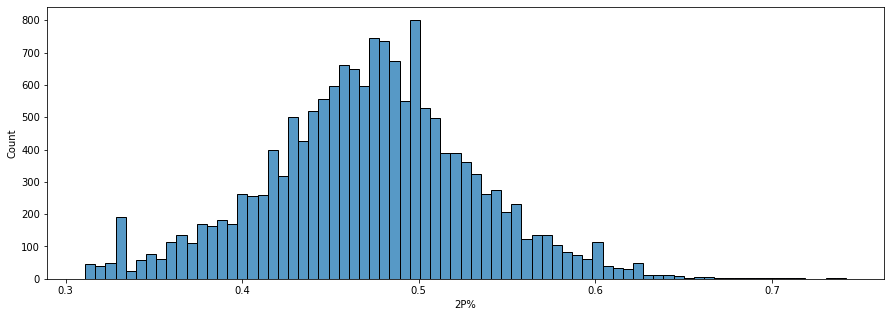

In [12]:
histogram(nba_dataset['2P%'])

We can see that there's still a few guys over 65% that may be outliers, let's check.

In [13]:
max_val = 0.65

outliers = nba_dataset.loc[(nba_dataset['2P%'] >= max_val) & (nba_dataset['2PA'] >= 250), :]
display(outliers)

,Player,Pos,Age,FGA,3PA,3P%,2PA,2P%,eFG%,FTA,...,STL%,BLK%,TOV%,USG%,WS,BPM,VORP,Share,Status,Season
94,Artis Gilmore,C,31,816,0,0.000,816,0.670,0.670,532,...,0.8,4.0,18.4,18.5,12.3,4.3,4.5,0.006,Candidate,1981
329,Mark West,C,28,372,0,0.000,372,0.653,0.653,202,...,0.8,5.1,18.3,11.1,5.5,1.0,1.5,0.000,OOR,1989
97,Erick Dampier,C,33,280,0,0.000,280,0.650,0.650,141,...,0.7,3.8,17.8,10.4,6.1,0.6,1.2,0.000,OOR,2009
84,Tyson Chandler,C,28,407,0,0.000,407,0.654,0.654,295,...,0.9,3.0,14.1,14.2,9.4,1.5,1.8,0.000,OOR,2011
245,DeAndre Jordan,C,22,341,1,0.000,340,0.688,0.686,217,...,1.0,5.4,18.8,11.7,5.2,-0.7,0.7,0.000,OOR,2011
85,Tyson Chandler,C,29,355,2,0.000,353,0.683,0.679,315,...,1.4,3.4,17.1,13.0,9.5,2.3,2.2,0.000,OOR,2012
12,Chris Andersen,C,35,275,12,0.250,263,0.662,0.649,169,...,1.2,6.1,13.2,13.8,6.0,1.2,1.1,0.000,OOR,2014
245,DeAndre Jordan,C,25,515,0,0.000,515,0.676,0.676,374,...,1.4,5.4,15.3,12.4,11.1,2.5,3.3,0.000,OOR,2014
353,Mason Plumlee,C,23,302,3,0.000,299,0.666,0.659,195,...,2.0,3.6,16.6,17.1,4.7,1.0,1.0,0.000,OOR,2014
474,Brandan Wright,C,26,331,0,0.000,331,0.677,0.677,106,...,1.5,4.2,8.5,17.4,5.1,3.4,1.5,0.000,OOR,2014


As expected, all centers that love the rim.

### FT% : Free Throw Percentage

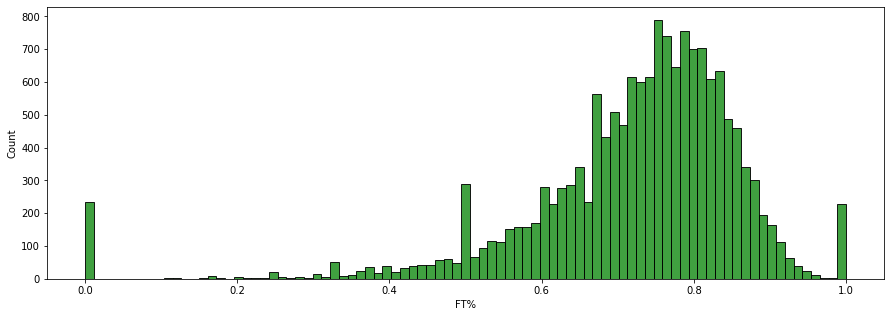

In [14]:
histogram(nba_dataset['FT%'],"Green")

It seems that too many guys had 0% or 100% accuracy. Again, weird numbers.

Gonna treat that, by taking the mean of Free Throw Attempts in count.

In [15]:
print(f"FTA mean: {nba_dataset['FTA'].mean():.0F}")

FTA mean: 146


So let's consider one third of the FTA mean (50 attempts) as the margin and see what happens.

In [16]:
df_size = nba_dataset.shape[0]
nba_dataset = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                              | (nba_dataset['Status'] != 'OOR'), :]
removed_rows = df_size - nba_dataset.shape[0]
print('{} rows removed'.format(removed_rows))

4671 rows removed


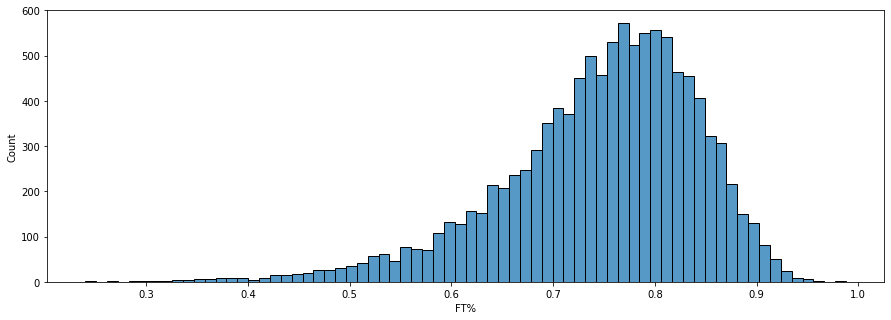

In [17]:
histogram(nba_dataset['FT%'])

#### Fun Fact Section

If you are wondering who are the guys below 35% free throw accuracy with 50 or more attempts, here are the nominees: 

In [18]:
dfloosers = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] <= 0.35), ['Player','Pos','FTA','FT%','Season']]

display(dfloosers.sort_values(by=['FT%','FTA'], ascending=[True,False]))

,Player,Pos,FTA,FT%,Season
313,Larry Smith,PF,50,0.240,1991
323,Olden Polynice,C,65,0.262,2001
128,Joey Dorsey,PF,83,0.289,2015
292,Ian Mahinmi,C,102,0.304,2015
284,Larry Smith,PF,58,0.310,1989
322,Olden Polynice,C,90,0.311,2000
86,Chris Dudley,PF,182,0.319,1990
51,Josh Boone,PF,58,0.328,2010
192,Steven Hunter,C,69,0.333,2004
110,DeSagana Diop,C,66,0.333,2009


A few famous names here. Congrats to the Wizards on drafting Kwame Brown as a first pick.

I think the ones with more than 95% should also have their names listed, so here it goes:

In [19]:
dfwow = nba_dataset.loc[(nba_dataset['FTA'] >= 50)
                        & (nba_dataset['FT%'] >= 0.95), ['Player','Pos','FTA','FT%','Season']]

display(dfwow.sort_values(by=['FT%','FTA'], ascending=[False,False]))

,Player,Pos,FTA,FT%,Season
50,Terrell Brandon,PG,84,0.988,2002
73,José Calderón,PG,154,0.981,2009
201,Calvin Murphy,PG,215,0.958,1981
1,Mahmoud Abdul-Rauf,PG,229,0.956,1994
9,Ray Allen,SG,249,0.952,2009
271,Mark Price,PG,62,0.952,1991
15,Ryan Anderson,PF,62,0.952,2014
178,Jeff Hornacek,SG,180,0.950,2000


Now that the hard work is done, we can take out the attempts features.

In [20]:
nba_dataset = nba_dataset.drop(columns=['3PA','2PA','FTA','FGA','3PAr','FTr'])
display(nba_dataset)
nba_dataset.info()

,Player,Pos,Age,3P%,2P%,eFG%,FT%,ORB,DRB,AST,...,STL%,BLK%,TOV%,USG%,WS,BPM,VORP,Share,Status,Season
0,Kareem Abdul-Jabbar,C,33,0.000,0.574,0.574,0.766,197,624,272,...,0.9,4.0,12.8,26.3,14.3,6.1,6.1,0.414,Candidate,1981
2,Alvan Adams,C,26,0.000,0.526,0.526,0.768,157,389,344,...,2.4,1.9,18.7,23.0,7.7,5.1,3.7,0.000,OOR,1981
4,Tiny Archibald,PG,32,0.000,0.505,0.499,0.816,36,140,618,...,1.3,0.4,21.8,17.5,6.9,-0.1,1.4,0.046,Candidate,1981
6,James Bailey,PF,23,0.500,0.499,0.500,0.709,192,415,98,...,1.4,3.1,17.3,20.3,4.9,-1.1,0.6,0.000,OOR,1981
7,Greg Ballard,SF,26,0.219,0.470,0.466,0.847,167,413,195,...,2.1,0.8,8.4,21.4,6.9,2.2,2.8,0.000,OOR,1981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,Delon Wright,PG,27,0.370,0.504,0.519,0.770,70,210,244,...,2.6,1.2,13.8,14.4,4.4,1.9,1.5,0.000,OOR,2020
523,Thaddeus Young,PF,31,0.356,0.501,0.513,0.583,94,221,117,...,2.8,1.4,13.9,19.7,1.9,-1.2,0.3,0.000,OOR,2020
524,Trae Young,PG,21,0.361,0.501,0.519,0.860,32,223,560,...,1.4,0.3,16.2,34.9,5.9,3.9,3.1,0.000,OOR,2020
525,Cody Zeller,C,27,0.240,0.577,0.543,0.682,160,251,88,...,1.5,1.7,11.9,20.8,3.6,-0.6,0.5,0.000,OOR,2020


<class 'pandas.core.frame.DataFrame'>
Int64Index: 10949 entries, 0 to 528
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  10949 non-null  object 
 1   Pos     10949 non-null  object 
 2   Age     10949 non-null  int64  
 3   3P%     10949 non-null  float64
 4   2P%     10949 non-null  float64
 5   eFG%    10949 non-null  float64
 6   FT%     10949 non-null  float64
 7   ORB     10949 non-null  int64  
 8   DRB     10949 non-null  int64  
 9   AST     10949 non-null  int64  
 10  STL     10949 non-null  int64  
 11  BLK     10949 non-null  int64  
 12  TOV     10949 non-null  int64  
 13  PF      10949 non-null  int64  
 14  PTS     10949 non-null  int64  
 15  PER     10949 non-null  float64
 16  TS%     10949 non-null  float64
 17  TRB%    10949 non-null  float64
 18  AST%    10949 non-null  float64
 19  STL%    10949 non-null  float64
 20  BLK%    10949 non-null  float64
 21  TOV%    10949 non-null  float64
 22  

In [21]:
full_nba_dataset = nba_dataset

## Models

#### Decision Tree

#### Feature Selection

In [22]:
df_clear = pd.DataFrame()
feature_list = ['3P%', '2P%', 'eFG%', 'FT%', 'ORB', 'DRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'PER', 'TS%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'WS', 'BPM', 'VORP']
# ['VORP','WS','PER','BPM','PTS']
feature_values = []

for feature in feature_list:
    for season in np.arange(1981,2021,1):
        df = full_nba_dataset.loc[(full_nba_dataset['Season'] == season), ['Season','Player',feature,'Status']]
        df = df.sort_values(by=feature, ascending= False)

        if season == 1981:
            df_clear = df.iloc[:1]
        else:
            df_clear = df_clear.append(df.iloc[:1])

    df = df_clear.groupby('Status').size().reset_index(name='counts')
    df = df.sort_values(by='Status')
    
    df = df.set_index(['Status'])
    
#     display(df)
#     importance = (df.iat[1,1]/(df.iat[1,1]+df.iat[0,1]))*100
    try:
        importance = (df.at['MVP','counts']/40)
    except:
        importance = 0

    feature_values.append('{:.2f}'.format(importance)) 

dfts = pd.DataFrame()
dfts['Features'] = feature_list
dfts['Importance'] = feature_values
display(dfts.sort_values(by='Importance',ascending=False)) 


,Features,Importance
20,WS,0.55
22,VORP,0.50
12,PER,0.50
21,BPM,0.47
11,PTS,0.25
19,USG%,0.17
5,DRB,0.10
7,STL,0.07
6,AST,0.07
13,TS%,0.05


3P%	0.018766
DRB	0.018592
TS%	0.017796
AST	0.016651
TOV%	0.016171
AST%	0.015202
STL	0.014527
eFG%	0.014288
TRB%	0.014069
ORB	0.013704
STL%	0.013133
2P%	0.012645
BLK	0.012509
BLK%	0.010437

In [23]:
def model_score(dataframe,model,features,iterations=1,path='./misses/trash'):
    
    nro_of_corrects = 0
    nro_of_top3_corrects = 0

    file = open(f"{path}/output.txt","w")
    
    file.write('Model : {}\n{} features : {}\n'.format(model,len(features),features))

    t1 = time.time()

    for season in np.arange(1981,2021,1):

        text = f' {season} |'

        y_train = dataframe.loc[(dataframe['Season'] != season),['Share']]
        y_train = np.ravel(y_train)
        y_test = dataframe.loc[(dataframe['Season'] == season),['Share']]
        y_test = np.ravel(y_test)

        X_train = dataframe.loc[(dataframe['Season'] != season),:].drop(['Share','Season'], axis=1)
        X_test = dataframe.loc[(dataframe['Season'] == season),:].drop(['Share','Season'], axis=1)

        players_rank = dict()
        df = full_nba_dataset.loc[(full_nba_dataset['Season'] == season),['Player','Share','Season']]
        df_truth = df.sort_values(by='Share', ascending=False)

        for i in range(iterations):

            model.fit(X_train, y_train)
            pred = model.predict(X_test)

            df['Pred'] = pred.tolist()
            df_pred = df.drop(['Share'],axis=1).sort_values(by='Pred', ascending=False)

            for j in range(5):
                if df_pred.iat[j,0] in players_rank.keys():
                    players_rank[df_pred.iat[j,0]] += (10-(j*2))
                else:
                    players_rank[df_pred.iat[j,0]] = (10-(j*2))

        players_columns = list(players_rank.keys())
        votes_columns = []

        for k in players_columns:
            votes_columns.append(players_rank[k])

        data = dict()
        data['Player'] = players_columns
        data['Season'] = season
        data['Pred'] = votes_columns

        df_pred_final = pd.DataFrame(data)
        df_pred_final = df_pred_final.sort_values(by='Pred', ascending=False)
        df_pred_final.to_csv(f"./predictions/{season}_pred.csv")

        pred_top3 = list(df_pred_final['Player'].iloc[:3])
        top3 = list(df_truth['Player'].iloc[:3]) 
        top3_success = list()

        for z in pred_top3:
            if z in top3:
                top3_success.append(z)

        df_comp = pd.DataFrame()

        if pred_top3[0] == top3[0]:
            sorf = 'Success'
            nro_of_corrects += 1
        else:
            sorf = 'Fail'
            df_comp = full_nba_dataset.loc[(full_nba_dataset['Season'] == season) & (full_nba_dataset['Player'] == top3[0]) ,:]
            df_comp = df_comp.append(full_nba_dataset.loc[(full_nba_dataset['Season'] == season) & (full_nba_dataset['Player'] == pred_top3[0]) ,:])
            df_comp['Label'] = ['Correct','Predicted']
            df_comp.to_csv('{}/{}_miss.csv'.format(path,season),index=False)

        text += '{:^10s}| '.format(sorf)


        text += f'{len(top3_success)} from de top3 correct | {top3_success} |\n'
        nro_of_top3_corrects += len(top3_success)

        file.write(str(text))
  
    plt.figure(figsize=(15, 10))
    tree.plot_tree(model)  
    plt.show()

    text = "GLOBAL_SUCCESS_RATE : {:.2%}\nGLOBAL_SUCCESS_RATE_TOP3 : {:.2%}\n".format((nro_of_corrects/40),(nro_of_top3_corrects/120))
    print(text)
    file.write(str(text))
    t2 = time.time()

    text = 'Time elapsed: {:.2f} seconds'.format(t2-t1)
    file.write(str(text))
    file.close()

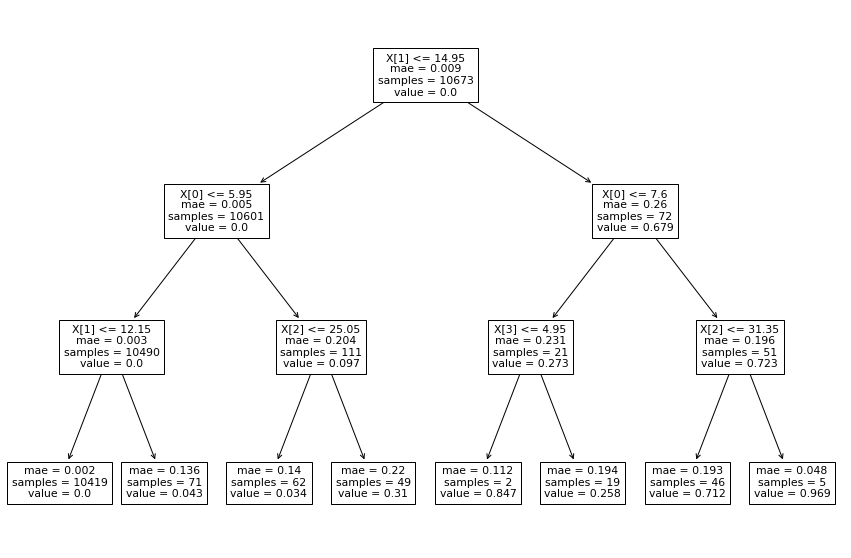

GLOBAL_SUCCESS_RATE : 55.00%
GLOBAL_SUCCESS_RATE_TOP3 : 61.67%



In [24]:
nba_dataset = full_nba_dataset[['VORP','WS','PER','BPM','Season','Share']]
choosen_model = tree.DecisionTreeRegressor(criterion='mae',max_depth=3)
model_score(dataframe=nba_dataset,model=choosen_model,features=['VORP','WS','PER','BPM'],iterations=1,path='./misses/decision_three')